# Lab 2b: Deep Learning Model (Part 2): Twitter Sentiment Analysis - Neural Network Modeling LSTM | Keras
by Group 8: Lu Han, Tony Chan, Michaela Hrabetova, Sangeeta Khanna, Cristina Endara# Lab 2b: Deep Learning Model (Part 1): Twitter Sentiment Analysis - Data cleaning and Data exploration
by Group 8: Lu Han, Tony Chan, Michaela Hrabetova, Sangeeta Khanna, Cristina Endara

In [1]:
# Original Source

Work is based on "Twitter Sentiment Analysis" by Paolo Ripamonti on [kaggle.com](https://www.kaggle.com/paoloripamonti/twitter-sentiment-analysis)

There are heavy modifications to the original work for code enhancements, encapsulation, improvement, bug fixing in order to make the original source work for this project. Eventually, a realization of deep learning model within a python class called SentimentInferencing. Python source can be found in sentiment.py

Sample Notebook from https://www.kaggle.com/paoloripamonti/twitter-sentiment-analysis

SyntaxError: invalid syntax (<ipython-input-1-d630e9a3939e>, line 3)

# Twitter Sentiment Analysis

In [2]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

Using TensorFlow backend.


In [3]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/tony/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Set up

In [4]:
# DATASET
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# FILE PATH
MYPATH = "../data/"

# EXPORT
KERAS_MODEL = MYPATH + "model.h5"
WORD2VEC_MODEL = MYPATH + "model.w2v"
TOKENIZER_MODEL = MYPATH + "tokenizer.pkl"
ENCODER_MODEL = MYPATH + "encoder.pkl"

In [5]:
# df = pd.read_csv('../input/training.1600000.processed.noemoticon.csv', encoding =DATASET_ENCODING , names=DATASET_COLUMNS)
df = pd.read_csv('../input/clean_tweet.csv')

In [6]:
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [7]:
%%time
df.target = df.target.apply(lambda x: decode_sentiment(x))

CPU times: user 356 ms, sys: 5.46 ms, total: 362 ms
Wall time: 362 ms


In [8]:
# Text is cleaned in previous section
# stop_words = stopwords.words("english")
# stemmer = SnowballStemmer("english")

In [9]:
# def preprocess(text, stem=False):
#     # Remove link,user and special characters
#     text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
#     tokens = []
#     for token in text.split():
#         if token not in stop_words:
#             if stem:
#                 tokens.append(stemmer.stem(token))
#             else:
#                 tokens.append(token)
#     return " ".join(tokens)


In [10]:
df = df.dropna()

In [11]:
df_small = df.sample(200000)

In [12]:
# save a section for later use
# df_small.to_csv('../data/clean_tweet_small.csv',encoding='utf-8')

# Train Test Split

In [13]:
df_train, df_test = train_test_split(df_small, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 160000
TEST size: 40000


In [14]:
%%time
documents = [_text.split() for _text in df_train.text] 

CPU times: user 288 ms, sys: 20.3 ms, total: 308 ms
Wall time: 308 ms


# Word2Vec Model

In [15]:
w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

In [16]:
w2v_model.build_vocab(documents)

2020-09-03 09:05:03,961 : INFO : collecting all words and their counts
2020-09-03 09:05:03,962 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-09-03 09:05:03,987 : INFO : PROGRESS: at sentence #10000, processed 117640 words, keeping 13248 word types
2020-09-03 09:05:04,011 : INFO : PROGRESS: at sentence #20000, processed 233359 words, keeping 19911 word types
2020-09-03 09:05:04,035 : INFO : PROGRESS: at sentence #30000, processed 349887 words, keeping 25221 word types
2020-09-03 09:05:04,056 : INFO : PROGRESS: at sentence #40000, processed 466096 words, keeping 29921 word types
2020-09-03 09:05:04,074 : INFO : PROGRESS: at sentence #50000, processed 583547 words, keeping 33950 word types
2020-09-03 09:05:04,094 : INFO : PROGRESS: at sentence #60000, processed 701352 words, keeping 37767 word types
2020-09-03 09:05:04,116 : INFO : PROGRESS: at sentence #70000, processed 817746 words, keeping 41308 word types
2020-09-03 09:05:04,136 : INFO : PROGRESS: at 

In [17]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 8599


In [18]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

d; awaiting finish of 6 more threads
2020-09-03 09:05:12,644 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-09-03 09:05:12,649 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-09-03 09:05:12,654 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-03 09:05:12,656 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-03 09:05:12,660 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-03 09:05:12,665 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-03 09:05:12,665 : INFO : EPOCH - 10 : training on 1875318 raw words (1377094 effective words) took 0.7s, 2089871 effective words/s
2020-09-03 09:05:13,325 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-09-03 09:05:13,326 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-09-03 09:05:13,333 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-

(44080896, 60010176)

In [19]:
w2v_model.most_similar("love")

2020-09-03 09:05:27,136 : INFO : precomputing L2-norms of word weight vectors


[('luv', 0.5188807249069214),
 ('loove', 0.4423258900642395),
 ('lovee', 0.42661675810813904),
 ('loves', 0.4188220500946045),
 ('looove', 0.41761842370033264),
 ('adore', 0.4107745289802551),
 ('loooove', 0.3899637460708618),
 ('loveee', 0.3821057081222534),
 ('miss', 0.37912696599960327),
 ('loving', 0.37819838523864746)]

# Tokenizing Text

In [20]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 67523
CPU times: user 1.92 s, sys: 68.5 ms, total: 1.99 s
Wall time: 1.91 s


In [21]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

CPU times: user 2.5 s, sys: 47.5 ms, total: 2.55 s
Wall time: 2.55 s


In [22]:
labels = df_train.target.unique().tolist()
labels.append(NEUTRAL)
labels

['NEGATIVE', 'POSITIVE', 'NEUTRAL']

In [23]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (160000, 1)
y_test (40000, 1)


In [24]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (160000, 300)
y_train (160000, 1)

x_test (40000, 300)
y_test (40000, 1)


In [25]:
y_train[:10]


array([[0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0]])

In [26]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(67523, 300)


In [27]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

# Building and Fitting Keras LSTM model

In [28]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 300)          20256900  
_________________________________________________________________
dropout_1 (Dropout)          (None, 300, 300)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 20,417,401
Trainable params: 160,501
Non-trainable params: 20,256,900
_________________________________________________________________


In [29]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [30]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

In [31]:
%%time
EPOCHS = 2
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Train on 144000 samples, validate on 16000 samples
Epoch 1/2
144000/144000 [==============================] - 234s 2ms/step - loss: 0.5566 - accuracy: 0.7126 - val_loss: 0.4793 - val_accuracy: 0.7755
Epoch 2/2
144000/144000 [==============================] - 227s 2ms/step - loss: 0.5064 - accuracy: 0.7522 - val_loss: 0.4649 - val_accuracy: 0.7818
CPU times: user 30min 45s, sys: 3min 59s, total: 34min 44s
Wall time: 7min 41s


# LSTM model accuracy

In [32]:
%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

40000/40000 [==============================] - 20s 503us/step

ACCURACY: 0.781499981880188
LOSS: 0.4693099992752075
CPU times: user 1min 23s, sys: 6.01 s, total: 1min 29s
Wall time: 20.1 s


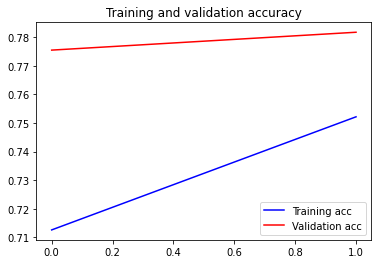

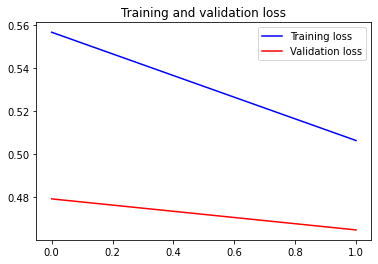

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [34]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

# Make Prediction

In [35]:
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at} 

In [36]:
predict("I love the music")

{'label': 'POSITIVE',
 'score': 0.9837818145751953,
 'elapsed_time': 0.14199090003967285}

In [37]:
predict("I hate the rain")


{'label': 'NEGATIVE',
 'score': 0.012632166966795921,
 'elapsed_time': 0.013457775115966797}

In [38]:
predict("i don't know what i'm doing")


{'label': 'POSITIVE',
 'score': 0.7644630074501038,
 'elapsed_time': 0.01371312141418457}

# Saving Model Objects

In [39]:
model.save(KERAS_MODEL)
w2v_model.save(WORD2VEC_MODEL)
pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=0)
pickle.dump(encoder, open(ENCODER_MODEL, "wb"), protocol=0)

2020-09-03 09:13:34,641 : INFO : saving Word2Vec object under ../data/model.w2v, separately None
2020-09-03 09:13:34,642 : INFO : not storing attribute vectors_norm
2020-09-03 09:13:34,642 : INFO : not storing attribute cum_table
2020-09-03 09:13:34,745 : INFO : saved ../data/model.w2v
